In [3]:
import pandas as pd
import numpy as np
import datetime 
import re
from urlextract import URLExtract
import spacy
import time
import pickle
import matplotlib.pyplot as plt


In [4]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px

In [5]:
extractor = URLExtract()
def replace_urls(x):
    urls = extractor.find_urls(x)
    if urls:
        x_new = replace_urls(x.replace(urls[0],''))
        return x_new
    else:
        return x

In [6]:
# this is a test... 

mh_df2 = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/mentalhealth_rand_large2019.csv', low_memory=False)
mh_df =  pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/mh_rand_large.csv', low_memory=False)

depression3 = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/depression_rand_large2019.csv', low_memory=False)
depression = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/depression_rand_large.csv', low_memory=False)

mh_df2.drop(columns=['Unnamed: 0'], inplace=True)
mh_df.drop(columns=['Unnamed: 0'], inplace=True)

depression3.drop(columns=['Unnamed: 0'], inplace=True)
depression.drop(columns=['Unnamed: 0'], inplace=True)

mh_df2['date'] = mh_df2.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))
mh_df['date'] = mh_df.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

depression3['date'] = depression3.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))
depression['date'] = depression.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

mh_df2.drop_duplicates(subset=['id'], inplace=True)
mh_df.drop_duplicates(subset=['id'], inplace=True)

depression3.drop_duplicates(subset=['id'], inplace=True)
depression.drop_duplicates(subset=['id'], inplace=True)

df_full = pd.concat([mh_df, mh_df2[mh_df2.date.dt.month!=10], depression, depression3[depression3.date.dt.month !=10]], ignore_index=True)


<AxesSubplot:xlabel='date,date'>

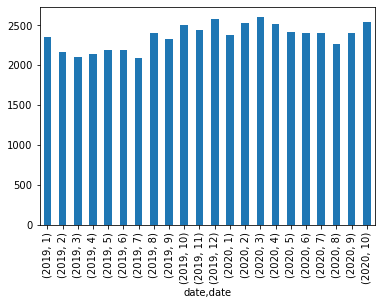

In [7]:
df_full.groupby([df_full["date"].dt.year, df_full["date"].dt.month]).size().plot(kind="bar")

In [ ]:
# mh_df2 = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/mh_rand_large2.csv', low_memory=False)
# mh_df =  pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/mh_rand_large.csv', low_memory=False)

# depression2 = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/depression_rand_large2.csv', low_memory=False)
# depression = pd.read_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/depression_rand_large.csv', low_memory=False)

# mh_df2.drop(columns=['Unnamed: 0'], inplace=True)
# mh_df.drop(columns=['Unnamed: 0'], inplace=True)

# depression2.drop(columns=['Unnamed: 0'], inplace=True)
# depression.drop(columns=['Unnamed: 0'], inplace=True)

# mh_df2['date'] = mh_df2.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))
# mh_df['date'] = mh_df.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

# depression2['date'] = depression2.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))
# depression['date'] = depression.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

# mh_df2.drop_duplicates(subset=['id'], inplace=True)
# mh_df.drop_duplicates(subset=['id'], inplace=True)

# depression2.drop_duplicates(subset=['id'], inplace=True)
# depression.drop_duplicates(subset=['id'], inplace=True)



In [ ]:
# df_full = pd.concat([mh_df, mh_df2, depression, depression2], ignore_index=True)
# df_full.columns.to_list()

In [ ]:
# df_full[df_full.date < '2020-10-20']
# df_full[df_full.date < '2020-03']

In [ ]:
# df_full.groupby([df_full["date"].dt.year, df_full["date"].dt.month]).size().plot(kind="bar")

In [8]:
# remove indents and urls and double spaces
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('\n',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('  ',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: replace_urls(x))

cols_of_interest = ['date', 'id', 'author', 'subreddit', 'title', 'selftext']
df_full_clean = df_full[(df_full.selftext != '[removed]') & (df_full.selftext != '[deleted]')].copy()
df_full_clean[cols_of_interest]

,date,id,author,subreddit,title,selftext
0,2019-10-11 16:39:05,dglq7k,liznormal23,mentalhealth,Mental Health Gray Area. Please help.,*TRIGGER WARNING: EATING DISORDER AND SUBSTANC...
1,2019-10-11 16:34:59,dgloc1,tacobean87,mentalhealth,what’s wrong with me ?,every single time i read something my mind blu...
2,2019-10-11 16:22:09,dglieu,AquilaVI,mentalhealth,I'm trying to deal with a deadly car crash. (A...,"Hello, people! A little backstory. I'll try to..."
3,2019-10-11 16:18:16,dglgl6,Mrcoolbaby,mentalhealth,Overwhelmed,I feel like my life is on loop. All the same k...
4,2019-10-11 16:15:26,dglfcf,TheA55M4N,mentalhealth,Anxiety and obsessions,I wrote my story here
...,...,...,...,...,...,...
51984,2019-09-19 11:34:17,d6gke6,keenstir,depression,Calling in Sick,I have called in sick at least 10 times since ...
51985,2019-09-19 11:33:20,d6gjwp,Jellybeanxx,depression,conversation with dad,please read. i have been on the journey for lo...
51986,2019-09-19 11:31:06,d6gisp,DankDank24,depression,My gf left me because she turned out to be les...,"I just miss her a lot, she's already moved on ..."
51987,2019-09-19 11:29:09,d6ghvp,feriou02,depression,Am I getting worse?,hello everyone. A long body of text for contex...


In [ ]:
stop_words = ['feel',
 'want',
 'myself',
 'people',
 'help',
 'depression',
 'nan',
 'fucking',
 'mental',
 'hate',
 'health',
 'life',
#  'need',
 'anxiety',
 'talk',
 'anymore',
 'die',
 'depressed',
 'friends',
 'fuck',
 'feeling',
#  'kill',
 'time',
 'shit',
 'tired',
 'happy',
 'better',
 'things',
 'going',
 'bad',
 'way',
 'care',
 'good',
 'wish',
 'person',
 'sad',
 'day',
 'makes',
 'years',
 'right',
 'tell',
 'self',
 'love',
 'worse',
 'try',
 'thoughts',
 'live',
 'friend',
 'stop',
 'feel',
 'help',
 'nan',
 'people',
 'fucking',
 'hate',
 'myself',
 'mental',
 'health',
 'depressed',
 'fuck',
 'shit',
 'self',
 'person',
 'makes',
 'friends',
 'feeling',
 'better',
 'depression',
 'wanna',
 'sad',
 'good',
 'way',
 'try',
 'understand',
 'wrong',
 'lonely',
#  'advice',
'&amp;#x200B;',
  'lose',
 'find',
 'care',
 'feelings',
 'idk',
 'emotions',
 'bad',
 'issues',
 'talking',
 'stupid',
 'actually',
 'ask',
 'like',
 'right',
 'thoughts',
 'guilty',
 'illness',
 'life',
 'therapy',
 'things',
 'social','best', 'bit', 'lot', 'great', 'says', 'getting', 'numb', 'come', 'amp', 'thing', 'little', 'today', 'started', 'maybe', 'feels', 'feel', 'feeling',
"told", 'tomorrow', 'everyday', 'future', 'reason', 'pay', 'got', 'said', 'everyday', 'tomorrow', 'week', 'old', 'start', 'anxious', 'able', 'tried', 'features']+ ['think', 'thinking', 'happen', 'look', 'not', 'have', 'will', 'ill', 'sorry', 'alot', 'point', 'cuz', 'kinda', 'tell', 'exist', 'wait','post', 'have'] + ['let','happen','think','word','kinda','say','matt']
              
              
              

In [ ]:
# path = '/Users/collinswestnedge/programming/Metis_Online/project_04/pickles/'

# with open(path+'stop_words_test.pickle', 'wb') as file:
#     pickle.dump(set(stop_words), file)

In [ ]:
# with open(path+'stop_words_test.pickle', 'rb') as file:
#     stop_words = pickle.load(file)

In [ ]:
class NLPPipe:
    
    def __init__(self, vectorizer, tokenizer, disable, pos, lemma=False):
        
        self.vectorizer = vectorizer
        self.tokenize = tokenizer
        self.disable = disable
        self.pos_list = pos
        self.lemma = lemma
    
    def process_text(self, text):

        nlp = spacy.load("en_core_web_sm")
        nlp.vocab[" "].is_stop = True
        nlp.vocab["like"].is_stop = True
        nlp.vocab["think"].is_stop = True
        nlp.vocab["know"].is_stop = True
        nlp.Defaults.stop_words |= set(stop_words)

        text_full = [] 
        for doc in nlp.pipe(text, disable=self.disable):
            # if part of speech list isnt empty return matches for pos
            if self.pos_list:
                tokens = [(ent.text) for ent in doc if not ent.is_stop and not ent.is_punct and ent.pos_ in self.pos_list]
                cleaned_text = " ".join(tokens)
                text_full.append(cleaned_text)
            elif self.lemma == True:
                tokens = [(ent.lemma_) for ent in doc if not ent.is_stop and not ent.is_punct]
                cleaned_text = " ".join(tokens)
                text_full.append(cleaned_text)
            else:
                tokens = [(ent.text) for ent in doc if not ent.is_stop and not ent.is_punct]
                cleaned_text = " ".join(tokens)
                text_full.append(cleaned_text)

        return text_full
    
    def fit(self, text):
        clean_text = self.process_text(text)
        return self.vectorizer.fit(clean_text)
    
    def transform(self, text):
        clean_text = self.process_text(text)
        return self.vectorizer.transform(clean_text)
    
    def fit_transform(self, text):
        clean_text = self.process_text(text)
        return self.vectorizer.fit_transform(clean_text)
    
    def display_topics(self, model, feature_names, no_top_words, topic_names=None):
        for ix, topic in enumerate(model.components_):
            if not topic_names or not topic_names[ix]:
                print("\nTopic ", ix)
            else:
                print("\nTopic: '",topic_names[ix],"'")
            print(", ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]])) 
    
    def fit_transform_nmf(self, nmf, word_vec, feature_names, n_words):
        '''
        Description:
        fit and display top words from nmf
        on vectorized words
        '''
#         nmf.fit(word_vect)
        doc_topic = nmf.fit_transform(word_vect)
        self.display_topics(nmf, feature_names, n_words)
        return doc_topic
    
#     def save_pipe(self, filename):
#         """
#         Writes the attributes of the pipeline to a file
#         allowing a pipeline to be loaded later with the
#         pre-trained pieces in place.
#         """
#         if type(filename) != str:
#             raise TypeError("filename must be a string")
#         pickle.dump(self.__dict__, open(filename+".mdl", 'wb'))
        
#     def load_pipe(self, filename):
#         """
#         Writes the attributes of the pipeline to a file
#         allowing a pipeline to be loaded later with the
#         pre-trained pieces in place.
#         """
#         if type(filename) != str:
#             raise TypeError("filename must be a string")
#         if filename[-4:] != '.mdl':
#             filename += '.mdl'
#         self.__dict__ = pickle.load(open(filename, 'rb'))

In [ ]:
# corpus = df_full_clean[['title','selftext']].sample(1)
# corpus.title.values[0]

In [ ]:
# def process_text(text, pos_list, lemma=False):

#     nlp = spacy.load("en_core_web_sm")
# #     nlp.vocab["myself"].is_stop = False
#     nlp.vocab[" "].is_stop = True
# #     nlp.vocab["like"].is_stop = True
# #     nlp.vocab["think"].is_stop = True
# #     nlp.vocab["know"].is_stop = True
#     nlp.Defaults.stop_words |= stop_words


#     text_full = [] 
#     for doc in nlp.pipe(text, disable=['parser', 'ner']):
#         # if part of speech list isnt empty return matches for pos
#         if pos_list:
#             tokens = [(ent.pos_) for ent in doc if not ent.is_stop and not ent.is_punct and ent.pos_ in pos_list]
#             cleaned_text = " ".join(tokens)
#             text_full.append(cleaned_text)
#         elif lemma == True:
#             tokens = [(ent.lemma_) for ent in doc if not ent.is_stop and not ent.is_punct]
#             cleaned_text = " ".join(tokens)
#             text_full.append(cleaned_text)
#         else:
#             tokens = [(ent.text) for ent in doc if not ent.is_stop and not ent.is_punct]
#             cleaned_text = " ".join(tokens)
#             text_full.append(cleaned_text)
            
#     return text_full

# # print(corpus.title.values[0])
# # print()

# a = process_text(['abandon', 'abandoned', 'abandonment', 'running', 'ran', 'runs'], pos_list=[], lemma=False)
# a

In [9]:
df_full_clean['text_title'] = df_full_clean.title + ' ' + df_full_clean.selftext

In [31]:
df_full_clean.to_csv('/Users/collinswestnedge/programming/Metis_Online/project_04/data/data_full_clean.csv')

In [30]:
df_full_clean

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,awarders,...,banned_by,date,author_created_utc,category,content_categories,media_embed,removal_reason,secure_media_embed,suggested_sort,text_title
0,[],False,liznormal23,NaN,[],NaN,text,t2_3e4lklg,False,[],...,NaN,2019-10-11 16:39:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mental Health Gray Area. Please help. *TRIGGER...
1,[],False,tacobean87,NaN,[],NaN,text,t2_4kyj8fmi,False,[],...,NaN,2019-10-11 16:34:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,what’s wrong with me ? every single time i rea...
2,[],False,AquilaVI,NaN,[],NaN,text,t2_j2m5u,False,[],...,NaN,2019-10-11 16:22:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I'm trying to deal with a deadly car crash. (A...
3,[],False,Mrcoolbaby,NaN,[],NaN,text,t2_3i29eu4o,False,[],...,NaN,2019-10-11 16:18:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Overwhelmed I feel like my life is on loop. Al...
4,[],False,TheA55M4N,NaN,[],NaN,text,t2_4cu0omsq,False,[],...,NaN,2019-10-11 16:15:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anxiety and obsessions I wrote my story here
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51984,[],False,keenstir,NaN,[],NaN,text,t2_5nkip,False,NaN,...,NaN,2019-09-19 11:34:17,NaN,NaN,NaN,NaN,NaN,NaN,confidence,Calling in Sick I have called in sick at least...
51985,[],False,Jellybeanxx,NaN,[],NaN,text,t2_5fux80z,False,NaN,...,NaN,2019-09-19 11:33:20,NaN,NaN,NaN,NaN,NaN,NaN,confidence,conversation with dad please read. i have been...
51986,[],False,DankDank24,NaN,[],NaN,text,t2_2vgrg0on,False,NaN,...,NaN,2019-09-19 11:31:06,NaN,NaN,NaN,NaN,NaN,NaN,confidence,My gf left me because she turned out to be les...
51987,[],False,feriou02,NaN,[],NaN,text,t2_21bgdfsf,False,NaN,...,NaN,2019-09-19 11:29:09,NaN,NaN,NaN,NaN,NaN,NaN,confidence,Am I getting worse? hello everyone. A long bod...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# corpus = df_full_clean.selftext
corpus = df_full_clean.text_title

tfdif_vect = TfidfVectorizer(
                             strip_accents='unicode',
                             min_df = 5,
                             ngram_range=(1, 1),
                             max_df = .5, 
                             token_pattern = r'\b[a-zA-Z]{3,}\b'
                             )

pipeline = NLPPipe(vectorizer=tfdif_vect,
                  tokenizer=None,
                  disable=["tagger","parser", "ner"],
                  pos=[],
                  lemma=True,
                  )

word_vect = pipeline.fit_transform(corpus).toarray()
features = pipeline.vectorizer.get_feature_names()

nmf = NMF(16, alpha=.04, l1_ratio=.5, random_state=0, max_iter=700, init='nndsvd')
doc_topic = pipeline.fit_transform_nmf(nmf, word_vect, features, n_words=100)
term_topic = nmf.components_

# reg_nmf = NMF(11, alpha=.05, l1_ratio=.5, random_state=0, max_iter=700)
# reg_doc_topic = pipeline.fit_transform_nmf(nmf, word_vect, features, n_words=100)
# reg_topic_term = nmf.components_

In [ ]:
# df = pd.DataFrame(word_vect)
# df.columns = pipeline.vectorizer.get_feature_names()
# df

In [11]:
path = '/Users/collinswestnedge/programming/Metis_Online/project_04/pickles/'

In [ ]:
# with open(path+'anxiety.pickle', 'wb') as file:
#     pickle.dump(nmf, file, protocol=4)
#     pickle.dump(doc_topic, file, protocol=4)
#     pickle.dump(word_vect, file, protocol=4)
#     pickle.dump(pipeline.vectorizer, file, protocol=4)

In [15]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
# once you feel good about topics you should move code below to new notebook

In [12]:
with open(path+'no_lemma_topic_model_big.pickle', 'rb') as file:
    reg_nmf = pickle.load(file)
    reg_doc_topic = pickle.load(file)
    reg_word_vec = pickle.load(file)
    reg_vectorizer = pickle.load(file)
    
    
with open(path+'lemma_topic_model_big.pickle', 'rb') as file:
    nmf_lemma = pickle.load(file)
    doc_topic_lemma = pickle.load(file)
    word_vec_lemma = pickle.load(file)
    vectorizer_lemma = pickle.load(file)
    

with open(path+'no_lemma_topic_model_big2.pickle', 'rb') as file:
    reg_nmf_large = pickle.load(file)
    reg_doc_topic_large = pickle.load(file)
    reg_word_vec_large = pickle.load(file)
    reg_vectorizer_large = pickle.load(file)
    

with open(path+'anxiety.pickle', 'rb') as file:
    anxiety_nmf = pickle.load(file)
    anxiety_doc_topic = pickle.load(file)
    anxiety_word_vec = pickle.load(file)
    anxiety_reg_vectorizer = pickle.load(file)
    

In [16]:
display_topics(anxiety_nmf, anxiety_reg_vectorizer.get_feature_names(), 100)
# display_topics(nmf_lemma, vectorizer_lemma.get_feature_names(), 100)


Topic  0
happen, mind, problem, hard, think, head, world, sure, normal, try, read, real, mean, remember, long, amp, kind, experience, hear, write, change, look, feel, moment, believe, brain, time, hope, cause, okay, weird, deal, stuff, pretty, guess, play, sense, come, matt, watch, situation, different, worry, constantly, struggle, idea, enjoy, probably, know, realize, sound, memory, place, game, control, question, share, voice, listen, make, fear, wonder, explain, video, etc, live, completely, act, usually, thank, family, face, want, forget, learn, get, body, see, negative, help, interest, give, big, recently, music, conversation, word, fact, say, suffer, away, sort, past, relate, post, dream, honestly, reality, inside, attention

Topic  1
not, will, mind, scare, stuff, parent, cause, worthless, head, problem, everytime, deserve, fuck, cut, alive, tho, bore, cant, annoy, bother, handle, motivation, okay, real, dumb, fix, matt, game, god, like, ask, pathetic, confuse, girl, tell, know

In [17]:
display_topics(nmf_lemma, vectorizer_lemma.get_feature_names(), 100)


Topic  0
happen, mind, problem, think, hard, head, normal, sure, world, try, have, read, real, remember, mean, kind, amp, long, hear, feel, write, experience, look, change, moment, deal, time, brain, believe, cause, weird, stuff, hope, okay, pretty, worry, come, guess, constantly, sense, play, idea, watch, situation, different, matt, probably, struggle, enjoy, know, sound, place, realize, memory, fear, make, control, game, voice, question, listen, share, explain, completely, wonder, etc, video, usually, act, family, live, recently, thank, forget, face, body, get, past, learn, negative, big, conversation, want, see, say, music, away, lately, word, sort, help, fact, give, dream, interest, relate, reality, post, suffer, notice

Topic  1
not, have, will, scare, mind, stuff, parent, suicidal, cause, problem, worthless, everytime, cut, tho, fuck, bore, deserve, head, hard, alive, cant, annoy, handle, motivation, bother, confuse, dumb, fix, god, okay, game, matt, real, attack, pathetic, like

In [ ]:
# general = reg_doc_topic[:,0]
# advice_support = reg_doc_topic[:,1]
# work = reg_doc_topic[:,2]
# school = reg_doc_topic[:,3]
# sleep = reg_doc_topic[:,5]
# family = reg_doc_topic[:,6]
# suicide = reg_doc_topic[:,7]
# relationship = reg_doc_topic[:,8]
# emotion = reg_doc_topic[:,9]
# fear = reg_doc_topic[:,10]
# eating_disorder = doc_topic_lemma[:,-1]
# anxiety = doc_topic_anxiety[:,-1]

In [18]:
general = reg_doc_topic[:,0]
advice_support = reg_doc_topic[:,1]
work = reg_doc_topic[:,2]
school = reg_doc_topic[:,3]
sleep = reg_doc_topic[:,5]
family = reg_doc_topic[:,6]
suicide = reg_doc_topic[:,7]
meds = reg_doc_topic_large[:,-2]
# idk = reg_doc_topic[:,4]
anxiety = anxiety_doc_topic[:,12]

emotion = doc_topic_lemma[:,9]
relationship = doc_topic_lemma[:,10]
eating_disorder = doc_topic_lemma[:,-1]
# anxiety = doc_topic_anxiety[:,-1]

In [ ]:
# testing = pd.DataFrame(reg_nmf.components_).T
# testing.index = reg_vectorizer.get_feature_names()
# testing.corr()

In [19]:
docs = df_full_clean[cols_of_interest + ['created_utc', 'text_title']].reset_index().drop(columns=['index', 'title'])

docs['professional_advice'] = general
docs['support']= advice_support
docs['work'] = work
docs['school'] = school
docs['sleep'] = sleep
docs['family'] = family
docs['suicide'] = suicide
docs['relationships'] = relationship
# docs['emotions'] = emotion
docs['meds'] = meds
docs['panic'] = anxiety
docs ['dietary_related'] = eating_disorder
# docs['anxiety'] = anxiety

docs['max_label'] = docs.select_dtypes(include=['float64']).idxmax(axis=1)
topic_doc_df = docs.copy()
# topic_doc_df.head()

In [ ]:
# topic_doc_df.select_dtypes('float').corr()

In [20]:
testing = topic_doc_df.sort_values(by=['panic'], ascending=False)
testing.values[3]

array([Timestamp('2020-06-06 22:27:31'), 'gy52ia', 'gafsr',
       'mentalhealth',
       "I am unsure of what could be a panic attack and what isn't",
       1591500451,
       "What can be considered a panic attack? I am unsure of what could be a panic attack and what isn't",
       0.017837555271690456, 0.0, 0.0, 0.0, 0.0021494620193750163, 0.0,
       0.0, 0.0, 0.03088615212162872, 0.11898850458039598, 0.0, 'panic'],
      dtype=object)

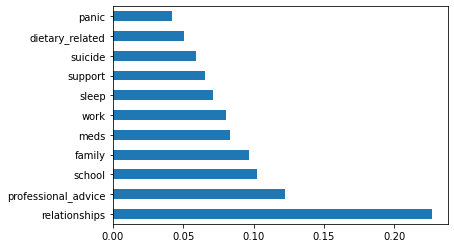

In [21]:
topic_doc_df.max_label.value_counts(normalize=True).plot(kind="barh");

In [23]:
topic_doc_df['hour'] = topic_doc_df.date.dt.hour
topic_doc_df['day'] = topic_doc_df.date.dt.day
topic_doc_df['month'] = topic_doc_df.date.dt.month
topic_doc_df['year'] = topic_doc_df.date.dt.year

In [25]:
pre_covid = topic_doc_df[topic_doc_df.date.dt.year == 2019]
post_covid = topic_doc_df[topic_doc_df.date.dt.year == 2020]

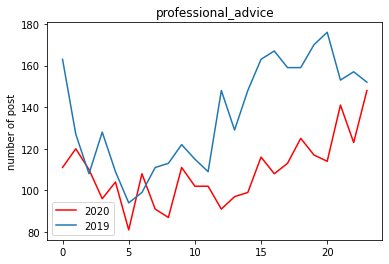

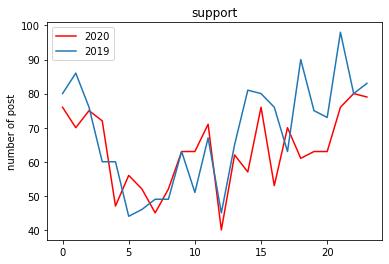

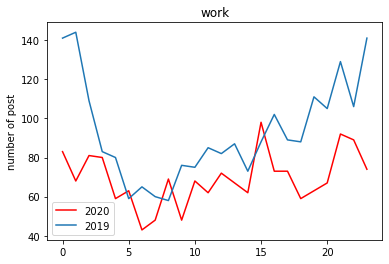

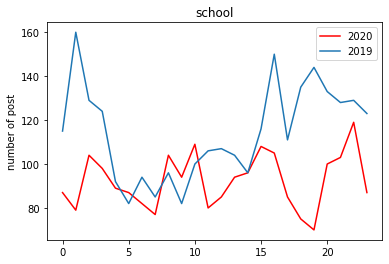

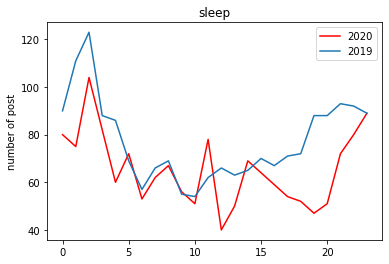

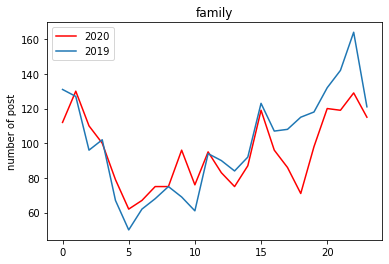

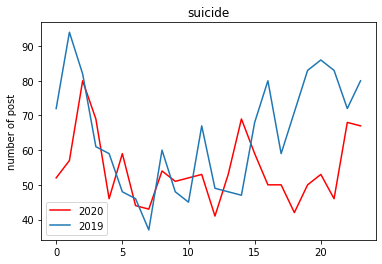

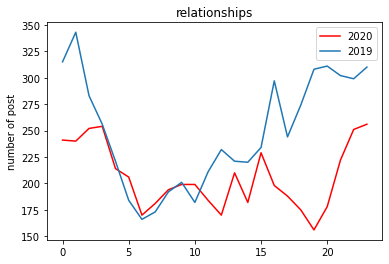

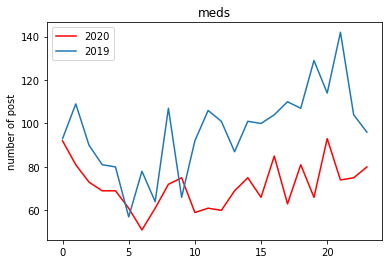

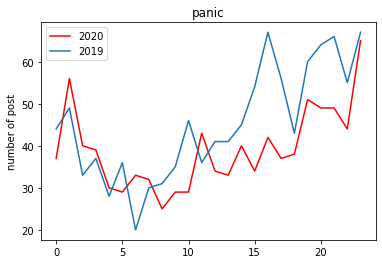

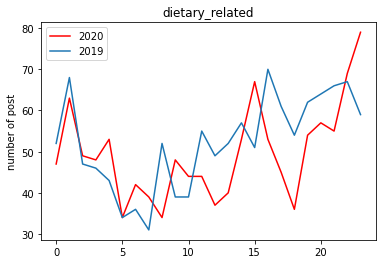

In [26]:
time_of_interest = 'hour'

a = post_covid.groupby(time_of_interest).max_label.value_counts().to_frame()
b = pre_covid.groupby(time_of_interest).max_label.value_counts().to_frame()

a.columns = ['max_label_count']
b.columns = ['max_label_count']

temp_a = a.reset_index()
temp_b = b.reset_index()

for col in topic_doc_df.select_dtypes('float').columns.to_list():
    plt.title(col)
    x = temp_a[temp_a.max_label == col][time_of_interest]
    y = temp_a[temp_a.max_label == col].max_label_count
    plt.plot(x, y, color='r')
    
    x2 = temp_b[temp_b.max_label == col][time_of_interest]
    y2 = temp_b[temp_b.max_label == col].max_label_count
    plt.plot(x2, y2)
    plt.legend(['2020', '2019'])
    plt.ylabel('number of post')
    plt.show()

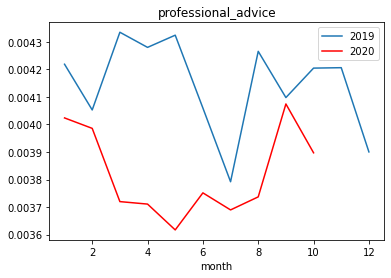

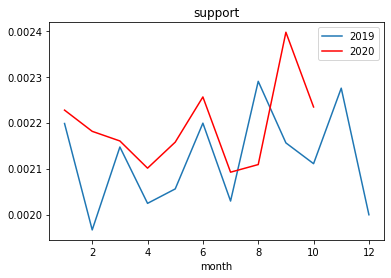

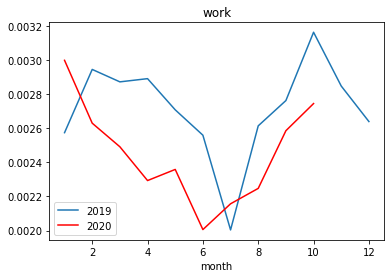

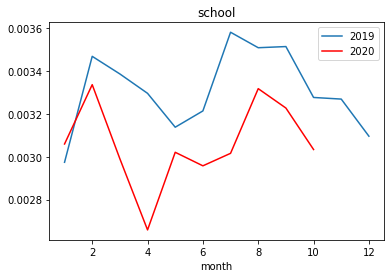

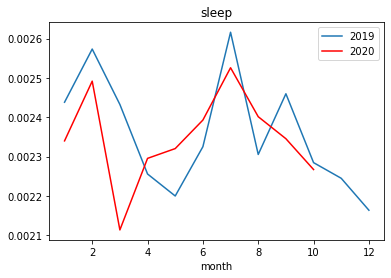

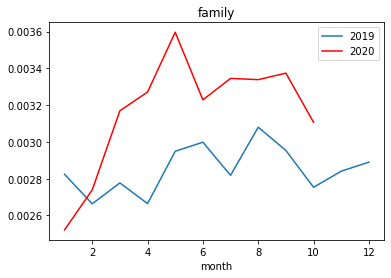

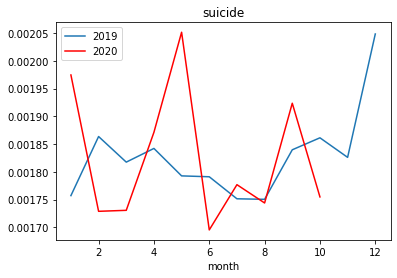

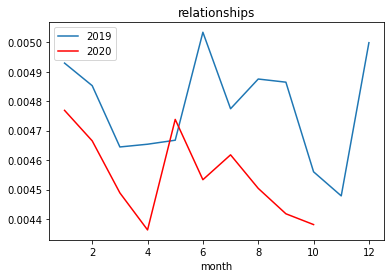

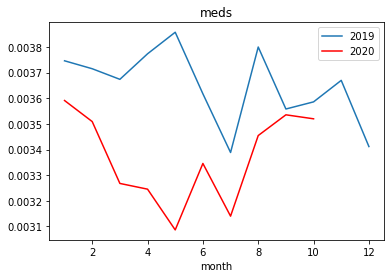

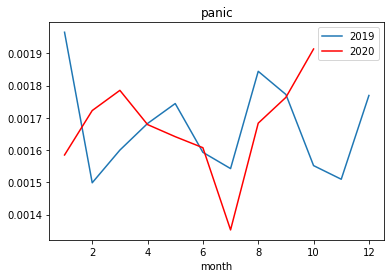

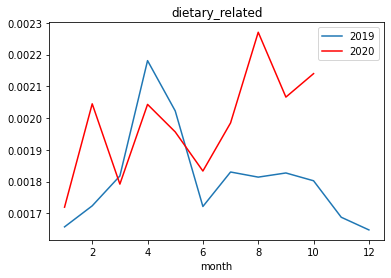

In [27]:
# date = "01/1/2020"
# epoch = int(time.mktime(datetime.datetime.strptime(date, "%m/%d/%Y").timetuple()))

for col in topic_doc_df.select_dtypes('float').columns.to_list():
    plt.title(col)
    pre_covid.groupby('month')[col].mean().plot()
    post_covid.groupby('month')[col].mean().plot(color='r')
    plt.legend(['2019', '2020'])
    plt.show()

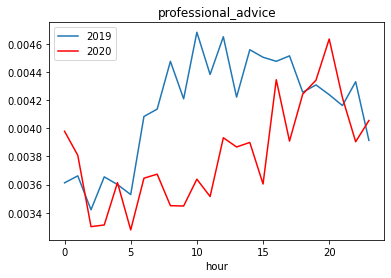

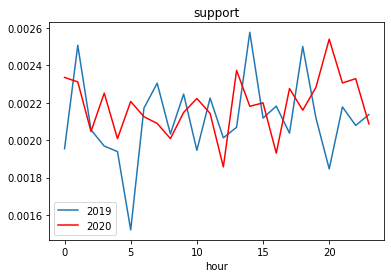

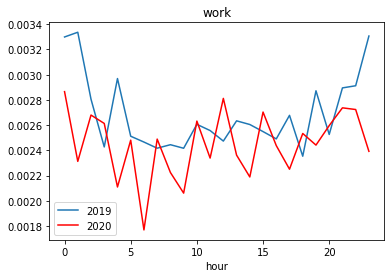

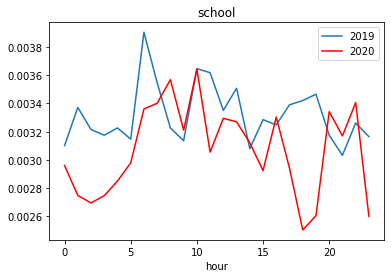

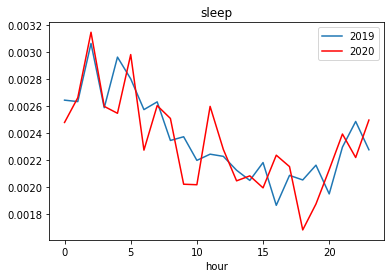

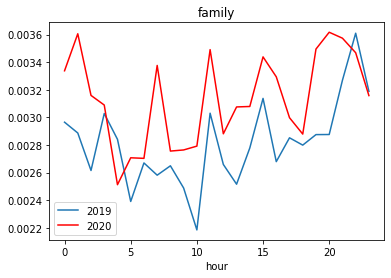

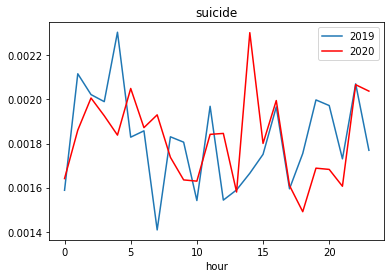

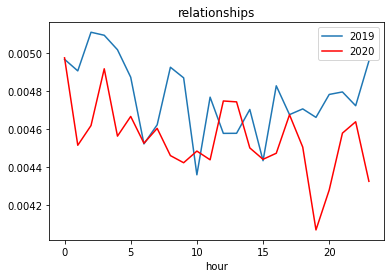

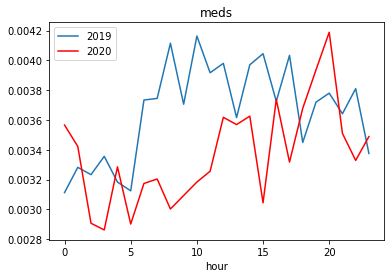

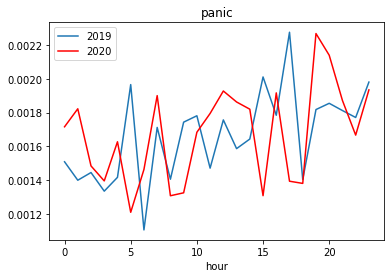

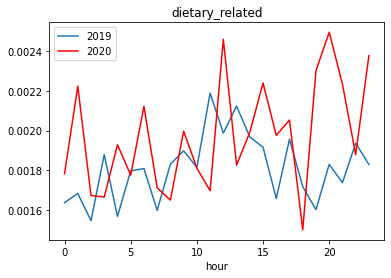

In [28]:
for col in topic_doc_df.select_dtypes('float').columns.to_list():
    plt.title(col)
    pre_covid.groupby('hour')[col].mean().plot()
    post_covid.groupby('hour')[col].mean().plot(color='r')
    plt.legend(['2019', '2020'])
#     plt.ylabel('average weight')
    plt.show()

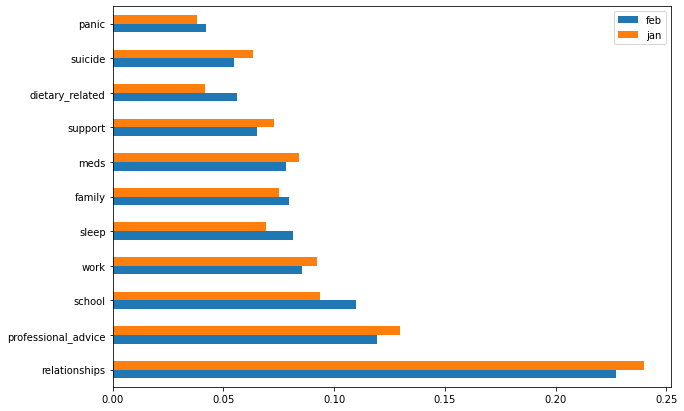

In [29]:
jan = topic_doc_df[(topic_doc_df.date.dt.month == 1) & (topic_doc_df.date.dt.year == 2020)]
feb = topic_doc_df[(topic_doc_df.date.dt.month == 2) & (topic_doc_df.date.dt.year == 2020)]

months = feb.max_label.value_counts(normalize=True).to_frame().merge(jan.max_label.value_counts(normalize=True).to_frame(), right_index=True, left_index=True)
months.columns = ['feb', 'jan']
months.plot.barh(figsize=(10,7));

# feb_means = feb.select_dtypes('float').mean().to_frame()
# jan_means = jan.select_dtypes('float').mean().to_frame()

# months = jan_means.merge(feb_means, right_index=True, left_index=True)
# months.columns = ['jan', 'feb']
# months.plot.barh(figsize=(10,7));

In [ ]:
import scattertext as st

category = 'relationships'
a = topic_doc_df[topic_doc_df.max_label == category].sample(1000)
b = topic_doc_df[topic_doc_df.max_label != category].sample(1000)

sample = pd.concat([a,b])

nlp = spacy.load("en_core_web_sm")
nlp.vocab[" "].is_stop = True
nlp.vocab["like"].is_stop = True
nlp.vocab["think"].is_stop = True
nlp.vocab["know"].is_stop = True
nlp.Defaults.stop_words |= set(stop_words)

corpus = st.CorpusFromPandas(sample,
                             category_col='max_label',
                             text_col='text_title',
                             nlp=nlp
                            ).build().remove_terms(set(stop_words), ignore_absences=True)

html = st.produce_scattertext_explorer(corpus,
          category=category,
          category_name=category,
          not_category_name='not '+ category,
          width_in_pixels=1000,
          minimum_term_frequency=10,
          pmi_threshold_coefficient=3,
          metadata=None)

open('scattertext_demo.html', 'wb').write(html.encode('utf-8'));

In [ ]:
# df = pd.DataFrame(reg_word_vec)
# df.columns = reg_vectorizer.get_feature_names()
# df['max_label'] = topic_doc_df.max_label
# df['text'] = topic_doc_df.text_title

In [ ]:
# test = topic_doc_df.max_label.apply(lambda x: 'anxiety' if x == 'anxiety' else 'not_anxiety')
# test2 = topic_doc_df.max_label.apply(lambda x: 1 if x == 'anxiety' else 0)
# test.values

In [ ]:
# # 	Tie-in to incorporate sckit-learn's various vectorizers into Scattertext
# from sklearn.datasets import fetch_20newsgroups
# from sklearn.feature_extraction.text import CountVectorizer
# from scattertext.CorpusFromScikit import CorpusFromScikit
# newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
# count_vectorizer = CountVectorizer()
# X_counts = count_vectorizer.fit_transform(newsgroups_train.data)

# corpus = CorpusFromScikit(
#                             X=reg_word_vec,
#                             y=test.values,
#                             feature_vocabulary=reg_vectorizer.vocabulary_,
#                             category_names=test2.values,
#                             raw_texts=topic_doc_df.selftext
#                              ).build()

# html = st.produce_scattertext_explorer(corpus,
#           category='anxiety',
#           category_name='anxiety',
#           not_category_name='not anxiety',
#           width_in_pixels=1000,
#           minimum_term_frequency=10,
#           pmi_threshold_coefficient=5,
#           metadata=None)